In [37]:
import pandas as pd
import numpy as np
import pysindy as ps
import math
from numpy import diff

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso

In [38]:
# t = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-62-t.csv')
# x = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-62-x.csv')
# xdot = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-62-x.csv')
# t = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-63-t.csv')
# x = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-63-x.csv')
# xdot = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-63-x.csv')

t = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-12-t.csv')
x = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-12-x.csv')
xdot = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-12-x.csv')

t = t.to_numpy() #0 to 1000
x = x.to_numpy() #1039 by 16
xdot = xdot.to_numpy()
# print(x.shape[0])
# print(type(x))
#print(x[:,2])

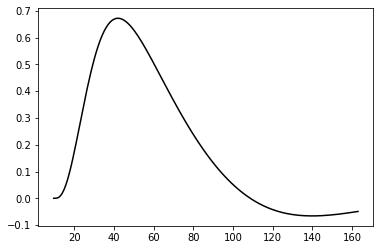

In [39]:
cl1 = x[20:200,1] - x[20:200,2]
plt.plot(t[20:200], cl1,'k')

In [40]:
#the case 1 with one column 
#
#create the training data
#index = math.floor(len(t)/2)#519
index = 140
#test 1 use u as a input
im = 25
t_train = t[im: index].flatten()

print(t_train.shape)
#training data
x_train = x [im:index]
x_dot_train = xdot [im:index]
#rint(x_train)
#it also need to y term which is x 2nd column - 3rd column
y = np.array([x[im:index,1] - x[im:index,2]])
#print(y.shape)
#concatenate the y to x_train 
x_train = np.concatenate((x_train, y.T), axis=1)
print(x_train.shape)

#compute the y_dot 
#ydt = diff(y.T)/diff(t_train)

#concatenate to x_dot_train

#x_dot_train = np.concatenate((x_dot_train, dydt.T), axis=1)

# test 2
#I will try to include u as one of the training input as well
#can I fit u to a single hill wave function with reasonable width
#and then pass it to the model as a input

(115,)
(115, 9)


In [41]:
#I will initial with only 2 functions: one is x 
# the other is the sigmoid-liked function
library_functions = [
    lambda x : x,
    lambda x : -2.5+5/(1+np.exp(-0.56*x)) #-e0+2*e0/(1+exp(-r*x))
]
library_function_names = [
    lambda x : x,
    lambda x : 'S(' + x + ')'
]

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

In [42]:
#pass the x and its derivative
optimizer = ps.SR3(threshold=0.001)
feature_library=custom_library

model = ps.SINDy(
    feature_library=feature_library,
    optimizer=optimizer
)
model.fit(x_train, t=t_train)
model.print()

(x0)' = 1.124 x0 + -6.309 x1 + -1.133 x2 + 1.685 x3 + 12549.433 x4 + 193493.702 x5 + -185.691 x6 + -598202.291 x7 + -6.072 x8 + -1.598 S(x0) + -6.221 S(x1) + 18.616 S(x2) + -0.984 S(x3) + -17929.308 S(x4) + -276380.527 S(x5) + 262.359 S(x6) + 854706.162 S(x7) + 22.969 S(x8)
(x1)' = -0.074 x0 + 0.426 x1 + -0.429 x2 + -0.020 x3 + -416.695 x4 + 6857.290 x5 + 2.304 x6 + -151303.541 x7 + 0.642 x8 + 0.106 S(x0) + -0.165 S(x1) + 0.119 S(x2) + 0.029 S(x3) + 596.839 S(x4) + -9797.263 S(x5) + -3.253 S(x6) + 216142.652 S(x7) + -1.326 S(x8)
(x2)' = -0.020 x1 + -5.700 x4 + -3536.356 x5 + 5.286 x6 + 10211.630 x7 + -0.007 x8 + 0.197 S(x1) + -0.169 S(x2) + 8.143 S(x4) + 5053.405 S(x5) + -7.550 S(x6) + -14588.046 S(x7) + -0.159 S(x8)
(x3)' = -412.646 x0 + 1932.741 x1 + 447.279 x2 + -1264.288 x3 + -3706410.621 x4 + -65505116.647 x5 + 78050.346 x6 + 195532579.233 x7 + 1779.043 x8 + 583.661 S(x0) + 2045.126 S(x1) + -5932.804 S(x2) + 1812.065 S(x3) + 5295726.289 S(x4) + 93567535.590 S(x5) + -110525.038 S(x

In [43]:
print('Model score: %f' % model.score(x_train))

Model score: -1.908585


In [ ]:
#simulate the result
dt = 0.5
t_test = np.arange(0, 200, dt)
#use the x_train at 10 ms value as x0_test
x0_test = x_train[24,:]
print(x_train[24,:])
x_test_sim = model.simulate(x0_test, t_test)

[9.55626777e-01 3.24013078e-02 9.27050157e-07 1.07045774e-01
 1.70748063e-02 1.28769632e-06 1.01296965e-04 9.57770151e-05
 3.24003807e-02]


In [ ]:
print(x_test_sim.shape[0])
cl1_sim = x_test_sim[:,1] - x_test_sim[:,2]
#cl2_sim = x_test_sim[:,9] - x_test_sim[:,10]

print(cl1_sim.shape)
#print(cl2_sim.shape)

In [ ]:
cl1 = x[:,1] - x[:,2]
#cl2 = x[:,9] - x[:,10]

#print(cl1)
#print(cl2.shape)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 9))
ax[0].plot(t, cl1,'k')
ax[0].plot( t_test, cl1_sim, 'r--')
ax[0].legend(['Cln 1','Cln 1_predicted'])
# ax[1].plot(t, cl2,'k', t_test, cl2_sim, 'r--')
# ax[1].legend(['Cln 2','Cln 2_predicted'])